In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special
from scipy.optimize import minimize 

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data
db = pd.read_csv('data/mon.csv')

# remove subjects with no lottery selections
badchoices = db[['sub','choice']].groupby('sub').sum()
badsubs = badchoices[badchoices['choice']<10].index.values
print("subs to remove for selecting only the ref", badsubs)

db = db[db['sub'].isin(badsubs) == False]

# add serial number for participants
db['subn'] = db['sub'].rank(method='dense').astype(int)-1
#db['subject'] = db['subn'].astype('category') 

# remove missing trials
db = db.dropna()
db['choice'] = db['choice'].astype('int')

# sort dataframe based on subject, makes it easier to compare the output of the models.
db = db.sort_values('subn').reset_index(drop=True)

# get final number of subject and trials
n_subs = db['subn'].unique().shape[0]
sub_idx = db.subn.tolist()
print("Final sample includ {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

subs to remove for selecting only the ref [11 14 16 40 50 65]
Final sample includ 45 subjects and 3736 valid trials


In [3]:
def MLE_riskamb(parameters):
    # extract parameters
    α, β, γ = parameters
    
    # caclulate proportion between SVs
    svLotto = (db_sub['value'].values ** α) * (1-(db_sub['risk'].values+(β * (db_sub['ambiguity'].values/2))))
    svRef = 5 ** α
    #p = 1/(1+np.exp((svRef - svLotto) * γ))
    p = special.expit((svRef - svLotto) * γ) 
    #size = len(p)
    #mu = np.random.binomial(1,p,size)
    
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(stats.norm.logpdf(db_sub.choice, p))
    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 

In [4]:
subs = db['sub'].unique()
mLL = pd.DataFrame()

for sub in subs:
    db_sub = db[db['sub']==sub]
    mle_model = minimize(MLE_riskamb, np.array([1,1,1]), method='L-BFGS-B', 
                         bounds=[(0,2),(-2,2),(-np.inf,np.inf)])
    x = mle_model.x
    temp = {'sub': sub, 'alpha_mll' : x[0], 'beta_mll': x[1], 'gamma_mll': x[2]}
    mLL = mLL.append(temp,ignore_index=True)
mLL.head()

,sub,alpha_mll,beta_mll,gamma_mll
0,10.0,1.045656,0.702963,-0.913222
1,13.0,0.000000,-1.645434,1.652535
2,15.0,0.415824,-2.000000,0.680583
3,18.0,0.000000,2.000000,-1.168623
4,19.0,2.000000,-1.129049,-0.001666


In [5]:
with pm.Model() as RiskAmb:
    # hyper
    aMu = pm.Normal('rMu', 0.7 ,1)
    aSig = pm.Exponential('rSig', 1)
    bMu = pm.Normal('aMu', 0,1)
    bSig = pm.Exponential('aSig', 1)
    
    gMu = pm.Normal('nMu', 0,1)
    gSig = pm.Exponential('nSig', 1)
    
    
    α = pm.TruncatedNormal('α', aMu, aSig, lower = 0, upper = 2, shape = n_subs)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    # Priors for unknown model parameters
    
      
    # Expected value of outcome
    svLotto = (db['value'].values ** α[sub_idx]) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace = pm.sample(4000, return_inferencedata=True, target_accept=0.95)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, α, nSig, nMu, aSig, aMu, rSig, rMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 335 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

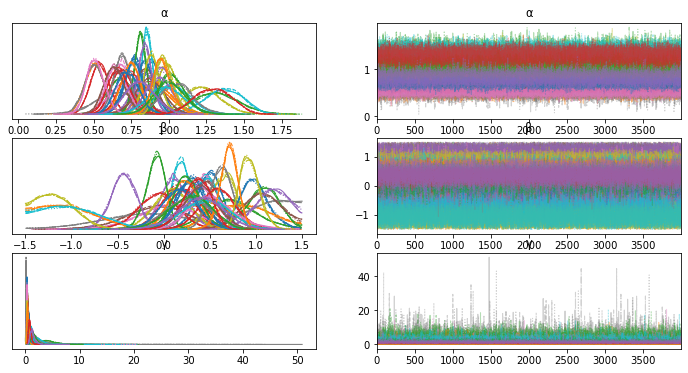

In [6]:
az.plot_trace(trace, var_names=['α','β','γ'])

In [7]:
with RiskAmb:
    ppc = pm.sample_posterior_predictive(trace)

<AxesSubplot:xlabel='choice / choice'>

/home/nachshon/anaconda3/envs/wmdm/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


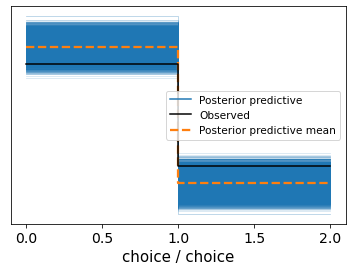

In [8]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb))

In [16]:
df = db[['sub','subn']].sort_values('subn').drop_duplicates().reset_index(drop=True)

age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans').iloc[:, [1,7,8]]
age.columns.values[0] = "sub"
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))

df = df.merge(age, left_on='sub', right_on='sub')

prop = pd.read_csv('results/mon_prop.csv')
df = df.merge(prop, left_on='sub', right_on='sub')


In [17]:
alpha = az.summary(trace, var_names=['α'])[['mean','sd']]
beta = az.summary(trace, var_names=['β'])[['mean','sd']]

alpha = alpha.rename(columns={'mean': "alpha_pymc", 'sd': 'alpha_sd'}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta_pymc", 'sd': 'beta_sd'}).reset_index(drop=True)

df = df.merge(alpha, left_index=True, right_index=True)
df = df.merge(beta, left_index=True, right_index=True)
df = df.merge(mLL, left_on='sub', right_on='sub')

In [11]:
def rna_select(subject, alpha, beta):
    uRef = 5 ** alpha
    uLotto = (subject.risk - beta*subject.ambiguity/2) * subject.value ** alpha
    p = special.expit(uLotto - uRef)
    choices = np.random.binomial(1, p, len(p))
    return np.mean(choices)

In [18]:
pred = pd.DataFrame()
for sub in df['subn'].unique():
    temp = db[db['subn']==sub]
    alpha = df[df['subn']==temp['subn'].iloc[0]]['alpha_pymc'].values
    beta  = df[df['subn']==temp['subn'].iloc[0]]['beta_pymc'].values
    select_bayes = rna_select(temp, alpha, beta)
    
    alpha = df[df['subn']==temp['subn'].iloc[0]]['alpha_mll'].values
    beta  = df[df['subn']==temp['subn'].iloc[0]]['beta_mll'].values
    select_mll = rna_select(temp, alpha, beta)
    
    temp = {"subn": sub, "predicted_bayes": select_bayes, "predicted_mll": select_mll}
    pred = pred.append(temp, ignore_index=True)
#pred['subn'] = pred.subn.astype(np.int64)

df = df.merge(pred, left_on='subn', right_on='subn')

In [19]:
df.corr()

,sub,subn,Age,Male,choice,alpha_pymc,alpha_sd,beta_pymc,beta_sd,alpha_mll,beta_mll,gamma_mll,predicted_bayes,predicted_mll
sub,1.000000,0.998218,0.089664,0.030739,0.031789,0.070720,-0.102336,-0.062156,-0.161397,0.060386,0.271474,-0.022523,0.031866,-0.079315
subn,0.998218,1.000000,0.078488,0.033693,0.033344,0.073573,-0.115113,-0.067540,-0.172462,0.036443,0.279757,-0.013534,0.036399,-0.103685
Age,0.089664,0.078488,1.000000,-0.379616,-0.234892,-0.138636,-0.047961,0.093142,-0.057542,-0.217220,0.028898,0.119634,-0.175788,-0.081241
Male,0.030739,0.033693,-0.379616,1.000000,-0.014784,-0.239553,-0.078570,-0.028702,0.075324,0.139566,0.047449,-0.185123,-0.060594,0.094973
choice,0.031789,0.033344,-0.234892,-0.014784,1.000000,0.007165,-0.024709,-0.224644,0.091230,0.302505,0.070831,0.259046,0.237599,0.107122
alpha_pymc,0.070720,0.073573,-0.138636,-0.239553,0.007165,1.000000,0.493633,-0.102363,-0.189031,0.115290,-0.041040,-0.231558,0.633130,0.021928
alpha_sd,-0.102336,-0.115113,-0.047961,-0.078570,-0.024709,0.493633,1.000000,-0.081853,0.684418,0.141648,-0.192831,-0.173276,0.240540,0.181495
beta_pymc,-0.062156,-0.067540,0.093142,-0.028702,-0.224644,-0.102363,-0.081853,1.000000,-0.254330,-0.084180,0.074256,-0.148816,-0.715334,0.020728
beta_sd,-0.161397,-0.172462,-0.057542,0.075324,0.091230,-0.189031,0.684418,-0.254330,1.000000,0.146116,-0.234861,0.075464,-0.001149,0.211803
alpha_mll,0.060386,0.036443,-0.217220,0.139566,0.302505,0.115290,0.141648,-0.084180,0.146116,1.000000,-0.286228,-0.225043,0.184505,0.820712


<AxesSubplot:xlabel='choice', ylabel='predicted_bayes'>

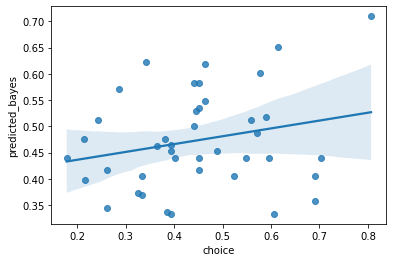

In [20]:
sns.regplot(x='choice', y='predicted_bayes', data=df)

<AxesSubplot:xlabel='choice', ylabel='predicted_mll'>

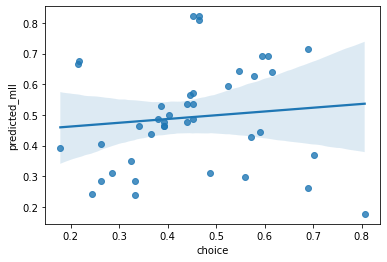

In [21]:
sns.regplot(x='choice', y='predicted_mll', data=df)

In [22]:
import scipy as sp

In [24]:
sp.stats.pearsonr(df.choice, df.predicted_bayes)

(0.23759869339435485, 0.1346955302697584)